## Classificador de nível de risco baseado em relatos de pacientes

### Instalação e importação das bibliotecas

In [1]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

SEED = 654

pln = spacy.load('pt_core_news_sm')

### Carregamento do dataset

In [3]:
df = pd.read_csv('../dataset/sintomas_doencas_cardiacas.csv', sep=';')
df.head()

,frase,diagnostico,risco
0,"Há três dias, estou sentindo dores fortes no p...",Infarto,Alto Risco
1,"Há pelo menos uma semana, venho apresentando u...",Insuficiência Cardíaca,Baixo Risco
2,"De repente, há dois dias, comecei a ter falta ...",Angina,Alto Risco
3,"Há quatro dias, sinto palpitações cardíacas fo...",Arritmia,Alto Risco
4,"Há uma semana, tenho uma sensação constante de...",Infarto,Alto Risco


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   frase        10 non-null     object
 1   diagnostico  10 non-null     object
 2   risco        10 non-null     object
dtypes: object(3)
memory usage: 372.0+ bytes


Text(0, 0.5, 'Contagem')

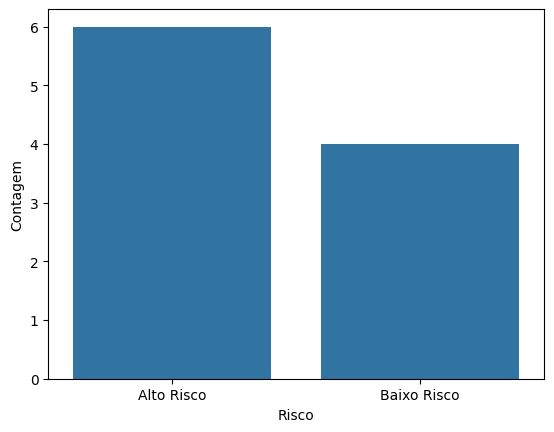

In [5]:
sns.countplot(df, x='risco')
plt.xlabel('Risco')
plt.ylabel('Contagem')

### Pré-processamento dos dados textuais

In [6]:
def text_processing(txt: str):
    """_summary_

    Args:
        txt (str): Texto a ser processado
        
    - Normaliza para minúsculas.
    - Remove stopwords, pontuações, acentuações e digítos numéricos.
    - Padroniza as palavras com a Lematização.
    """
    txt = txt.lower()
    doc = pln(txt)
    
    words: list[str] = []
    
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            words.append(token.lemma_)
    
    words = ' '.join(unidecode(word) for word in words)
    return words

In [7]:
df['frase_processada'] = df['frase'].apply(text_processing)
df.head()

,frase,diagnostico,risco,frase_processada
0,"Há três dias, estou sentindo dores fortes no p...",Infarto,Alto Risco,haver dia sentir dor forte peito pior esforco ...
1,"Há pelo menos uma semana, venho apresentando u...",Insuficiência Cardíaca,Baixo Risco,haver semana venho apresentar cansaco extremo ...
2,"De repente, há dois dias, comecei a ter falta ...",Angina,Alto Risco,repente haver dia comecar ar subito dificuldad...
3,"Há quatro dias, sinto palpitações cardíacas fo...",Arritmia,Alto Risco,haver dia sinto palpitacao cardiaca forte cora...
4,"Há uma semana, tenho uma sensação constante de...",Infarto,Alto Risco,haver semana sensacao constante aperto torax p...


**Tokenização das frases com TF-IDF e Ngrams**

In [8]:
tf_idf = TfidfVectorizer(lowercase=False, max_features=100, ngram_range=(1,2)) # lowercase=False pois o texto já é convertido para letras minúsculas
bow = tf_idf.fit_transform(df['frase_processada']) # Bag of Words

bow.shape

(10, 100)

Realizado estratificação dos dados (equilibrar os rótulos entre treino e teste) para melhorar o desempenho do modelo.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(bow, df['risco'], stratify=df['risco'], random_state=SEED)

### Treinamento de alguns modelos de classificação

In [10]:
labels = np.unique(df['risco'])

**Regressão Logística**

In [11]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

lr_model_acc = lr_model.score(X_test, y_test)
print(f'Acurácia do modelo: {lr_model_acc*100:.2f}%')

Acurácia do modelo: 66.67%


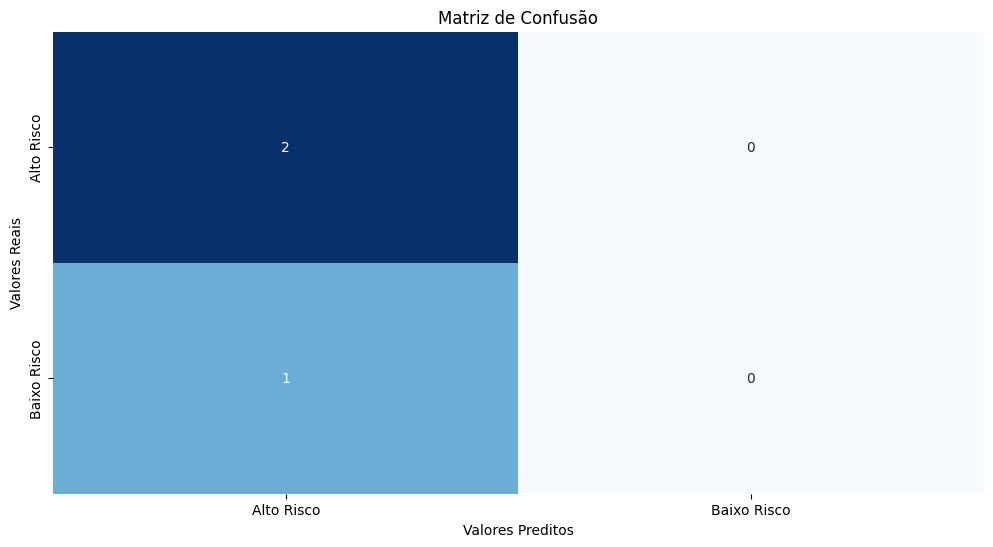

In [12]:
predicts_lr = lr_model.predict(X_test)

cm_lr = confusion_matrix(y_test, predicts_lr)

plt.figure(figsize=(12,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

In [13]:
print(classification_report(y_test, predicts_lr, zero_division=False))

              precision    recall  f1-score   support

  Alto Risco       0.67      1.00      0.80         2
 Baixo Risco       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



**Floresta Aleatória**

In [14]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_model_acc = rf_model.score(X_test, y_test)
print(f'Acurácia do modelo: {rf_model_acc*100:.2f}%')

Acurácia do modelo: 66.67%


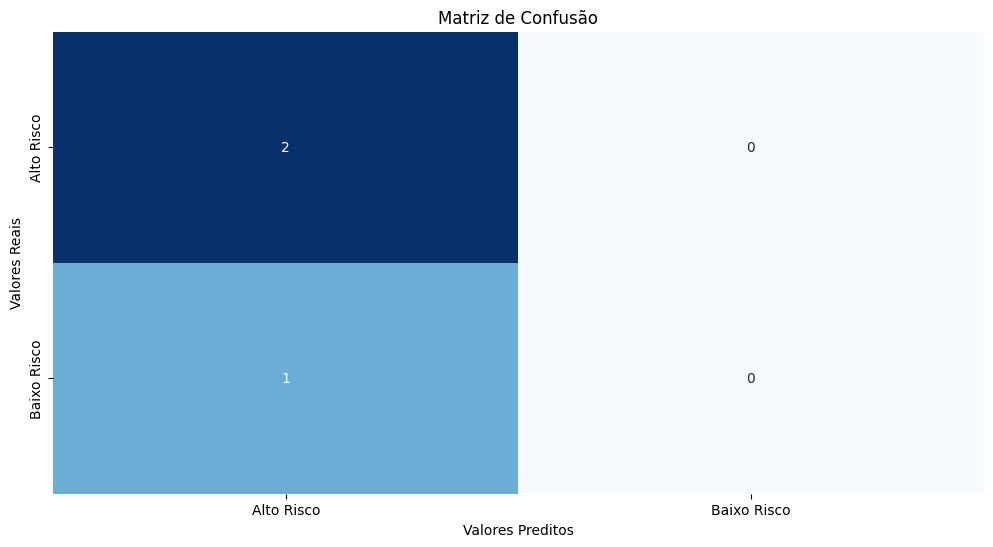

In [15]:
predicts_rf = rf_model.predict(X_test)

cm_rf = confusion_matrix(y_test, predicts_rf)

plt.figure(figsize=(12,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

In [16]:
print(classification_report(y_test, predicts_lr, zero_division=False))

              precision    recall  f1-score   support

  Alto Risco       0.67      1.00      0.80         2
 Baixo Risco       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



In [17]:
dump(lr_model, 'modelo_nivel_risco.joblib')
dump(tf_idf, 'tfidf_vectorizer_nivel_risco.joblib')

['tfidf_vectorizer_nivel_risco.joblib']

## Conclusão

Pelo fato de não termos uma base de dados tão grande e diversificada não foi possivel adquirir uma boa pontuação de acurácia, precisão, recall ou f1 score. Porém, o fluxo do algoritmo pode ser reutilizado para diversos contextos além de problemas médicos, pois o processo que fizemos de pré-processamento e tokenização com a estratégia da lematização é genérico, assim como, o processo de treinamento e teste do modelo também poderiam ser reutilizados para outros problemas. Portando, por mais que o resultado deste modelo não seja tão satisfatório para uso em produção, o problema não está relacionado com o fluxo do algoritmo, mas sim com a ausência de uma massa de dados significativa para criar um modelo robusto.